In [1]:
import pygame
from numpy.random import randn
import math
from math import sqrt
from math import atan2
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import ExtendedKalmanFilter
from numpy import eye, array, asarray
import numpy as np
import sympy
from IPython.display import display
from sympy.abc import alpha, x, y, v, w, R, theta
from sympy import symbols, Matrix

pygame 2.0.0.dev6 (SDL 2.0.10, python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
from math import sqrt

def H_of(x, landmark_pos):
    """ compute Jacobian of H matrix where h(x) computes 
    the range and bearing to a landmark for state x """

    px = landmark_pos[0]
    py = landmark_pos[1]
    hyp = (px - x[0, 0])**2 + (py - x[1, 0])**2
    dist = sqrt(hyp)

    H = array(
        [[-(px - x[0, 0]) / dist, -(py - x[1, 0]) / dist, 0],
         [ (py - x[1, 0]) / hyp,  -(px - x[0, 0]) / hyp, -1]])
    return H

from math import atan2

def Hx(x, landmark_pos):
    """ takes a state variable and returns the measurement
    that would correspond to that state.
    """
    px = landmark_pos[0]
    py = landmark_pos[1]
    dist = sqrt((px - x[0, 0])**2 + (py - x[1, 0])**2)

    Hx = array([[dist],
                [atan2(py - x[1, 0], px - x[0, 0]) - x[2, 0]]])
    return Hx

In [3]:
from filterpy.kalman import ExtendedKalmanFilter as EKF
from numpy import array, sqrt
class RobotEKF(EKF):
    def __init__(self, dt, wheelbase, std_vel, std_steer):
        EKF.__init__(self, 3, 2, 2)
        self.dt = dt
        self.wheelbase = wheelbase
        self.std_vel = std_vel
        self.std_steer = std_steer

        a, x, y, v, w, theta, time = symbols(
            'a, x, y, v, w, theta, t')
        d = v*time
        beta = (d/w)*sympy.tan(a)
        r = w/sympy.tan(a)
    
        self.fxu = Matrix(
            [[x-r*sympy.sin(theta)+r*sympy.sin(theta+beta)],
             [y+r*sympy.cos(theta)-r*sympy.cos(theta+beta)],
             [theta+beta]])

        self.F_j = self.fxu.jacobian(Matrix([x, y, theta]))
        self.V_j = self.fxu.jacobian(Matrix([v, a]))

        # save dictionary and it's variables for later use
        self.subs = {x: 0, y: 0, v:0, a:0, 
                     time:dt, w:wheelbase, theta:0}
        self.x_x, self.x_y, = x, y 
        self.v, self.a, self.theta = v, a, theta

    def predict(self, u):
        self.x = self.move(self.x, u, self.dt)
        self.subs[self.x_x] = self.x[0, 0]
        self.subs[self.x_y] = self.x[1, 0]

        self.subs[self.theta] = self.x[2, 0]
        self.subs[self.v] = u[0]
        self.subs[self.a] = u[1]

        F = array(self.F_j.evalf(subs=self.subs)).astype(float)
        V = array(self.V_j.evalf(subs=self.subs)).astype(float)

        # covariance of motion noise in control space
        M = array([[self.std_vel*u[0]**2, 0], 
                   [0, self.std_steer**2]])

        self.P = F @ self.P @ F.T + V @ M @ V.T

    def move(self, x, u, dt):
        hdg = x[2, 0]
        vel = u[0]
        steering_angle = u[1]
        dist = vel * dt

        if abs(steering_angle) > 0.001: # is robot turning?
            beta = (dist / self.wheelbase) * tan(steering_angle)
            r = self.wheelbase / tan(steering_angle) # radius

            dx = np.array([[-r*sin(hdg) + r*sin(hdg + beta)], 
                           [r*cos(hdg) - r*cos(hdg + beta)], 
                           [beta]])
        else: # moving in straight line
            dx = np.array([[dist*cos(hdg)], 
                           [dist*sin(hdg)], 
                           [0]])
        return x + dx


In [4]:
def residual(a, b):
    """ compute residual (a-b) between measurements containing 
    [range, bearing]. Bearing is normalized to [-pi, pi)"""
    y = a - b
    y[1] = y[1] % (2 * np.pi)    # force in range [0, 2 pi)
    if y[1] > np.pi:             # move to [-pi, pi)
        y[1] -= 2 * np.pi
    return y


In [7]:
from filterpy.stats import plot_covariance_ellipse
from math import sqrt, tan, cos, sin, atan2
import matplotlib.pyplot as plt

dt = 1.0/8.0

def z_landmark(lmark, sim_pos, std_rng, std_brg):
    x, y = sim_pos[0, 0], sim_pos[1, 0]
    d = np.sqrt((lmark[0] - x)**2 + (lmark[1] - y)**2)  
    a = atan2(lmark[1] - y, lmark[0] - x) - sim_pos[2, 0]
    z = np.array([[d + randn()*std_rng],
                  [a + randn()*std_brg]])
    return z

def ekf_update(ekf, z, landmark):
    ekf.update(z, HJacobian=H_of, Hx=Hx, 
               residual=residual,
               args=(landmark), hx_args=(landmark))
def run_localization(landmarks, std_vel, std_steer, 
                     std_range, std_bearing,
                     step=8, ellipse_step=8, ylim=None):
    ekf = RobotEKF(dt, wheelbase=0.5, std_vel=std_vel, 
                   std_steer=std_steer)
    ekf.x = array([[10, 0, 0]]).T # x, y, steer angle
    ekf.P = np.diag([.1, .1, .1])
    ekf.R = np.diag([std_range**2, std_bearing**2])

    sim_pos = ekf.x.copy() # simulated position
    # steering command (vel, steering angle radians)
    u = array([5, 0.0499]) 
    a1 = []
    b1 = []
    c1 = []
    d1 = []
    x_pred = []
    x_upt= []
    y_pred = []
    y_upt = []
    track_x = []
    track_y = []
    plt.figure()
    plt.scatter(landmarks[:, 0], landmarks[:, 1],
                marker='s', s=60)
    
    track = []
    NN = 100
    for i in range(NN):
        track_x = np.append(track_x,sim_pos[0, 0])
        track_y = np.append(track_y,sim_pos[1, 0])
        sim_pos = ekf.move(sim_pos, u, dt) # simulate robot
        track.append(sim_pos)
        ekf.predict(u=u)
        plot_covariance_ellipse((ekf.x[0,0], ekf.x[1,0]), ekf.P[0:2, 0:2], std=6, facecolor='k', alpha=0.3)
        x_pred = np.append(x_pred,ekf.x[0,0])
        y_pred = np.append(y_pred,ekf.x[1,0])
        if (i % step != 0):
            a1 = np.append(a1, ekf.P[0,0])
            b1 = np.append(b1, ekf.P[0,1])
            c1 = np.append(c1, ekf.P[1,0])
            d1 = np.append(d1, ekf.P[1,1])
       
        

        if i % step == 0:
            
            

               
            

            x, y = sim_pos[0, 0], sim_pos[1, 0]
            for lmark in landmarks:
                z = z_landmark(lmark, sim_pos,std_range, std_bearing)
                ekf_update(ekf, z, lmark)
                a1 = np.append(a1, ekf.P[0,0])
                b1 = np.append(b1, ekf.P[0,1])
                c1 = np.append(c1, ekf.P[1,0])
                d1 = np.append(d1, ekf.P[1,1])
                x_upt = np.append(x_upt,ekf.x[0,0])
                y_upt = np.append(y_upt,ekf.x[1,0])
                

            if i % ellipse_step == 0:
                plot_covariance_ellipse((ekf.x[0,0], ekf.x[1,0]), ekf.P[0:2, 0:2],std=6, facecolor='g', alpha=0.8)
                
    track = np.array(track)
    #track_x = track[:, 0]
    #track_y = track[:, 1]
    plt.plot(track[:, 0], track[:,1], color='k', lw=2)
    plt.axis('equal')
    plt.title("EKF Robot localization")
    if ylim is not None: plt.ylim(*ylim)
    plt.show()
    return [ekf, track_x,track_y, a1, b1, c1, d1, x_pred, y_pred, x_upt, y_upt]
    #return ekf

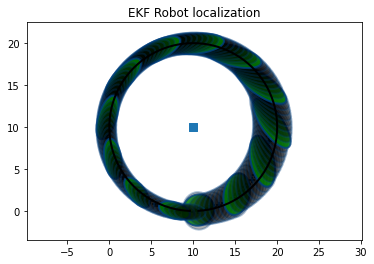

Final P: [0.0960412  0.02566553 0.00127283]


In [8]:
landmarks = array([[10, 10], [10, 5], [15, 15], [20, 5]])


ekf, track_x, track_y, a1, b1, c1, d1, x_pred, y_pred, x_upt, y_upt = run_localization(
    landmarks[0:1], std_vel=1.e-10, std_steer=1.e-10,
    std_range=1.4, std_bearing=.05)
print('Final P:', ekf.P.diagonal())


In [7]:



def draw_dashed_line(surf, color, start_pos, end_pos, width=3, dash_length=10):
    x1, y1 = start_pos
    x2, y2 = end_pos
    dl = dash_length

    if (x1 == x2):
        ycoords = [y for y in range(y1, y2, dl if y1 < y2 else -dl)]
        xcoords = [x1] * len(ycoords)
    elif (y1 == y2):
        xcoords = [x for x in range(x1, x2, dl if x1 < x2 else -dl)]
        ycoords = [y1] * len(xcoords)
    else:
        a = abs(x2 - x1)
        b = abs(y2 - y1)
        c = round(math.sqrt(a**2 + b**2))
        dx = dl * a / c
        dy = dl * b / c

        xcoords = [x for x in np.arange(x1, x2, dx if x1 < x2 else -dx)]
        ycoords = [y for y in np.arange(y1, y2, dy if y1 < y2 else -dy)]

    next_coords = list(zip(xcoords[1::2], ycoords[1::2]))
    last_coords = list(zip(xcoords[0::2], ycoords[0::2]))
    for (x1, y1), (x2, y2) in zip(next_coords, last_coords):
        start = (round(x1), round(y1))
        end = (round(x2), round(y2))
        pygame.draw.line(surf, color, start, end, width)




In [8]:
lambda_1 = [None]* 100
lambda_2 = [None]* 100
for m in range((100)):
    lambda_1[m]= (a1[m]+d1[m])/2 + math.sqrt(math.pow((a1[m]-d1[m])/2,2)+ math.pow(b1[m],2))
    lambda_2[m] = (a1[m] + d1[m]) / 2 - math.sqrt(math.pow((a1[m] - d1[m]) / 2, 2) + math.pow(b1[m],2))
    lambda_1[m] = math.sqrt(lambda_1[m]) *40
    lambda_2[m] = math.sqrt(lambda_2[m]) *40

for i in range (len(track_x)):
    track_x[i]= (track_x[i]*10)+ 240

for i in range (len(track_y)):
    track_y[i]= (track_y[i]*10)+ 150

for i in range (len(x_pred)):
    x_pred[i]= (x_pred[i]*10)+ 240

for i in range (len(y_pred)):
    y_pred[i]= (y_pred[i]*10)+ 150

for i in range (len(x_upt)):
    x_upt[i]= (x_upt[i]*10)+ 240

for i in range (len(y_upt)):
    y_upt[i]= (y_upt[i]*10)+ 150

In [9]:
# Define some colors

BLACK = (0, 0, 0)
WHITE = (255, 255, 255)
GREEN = (0, 255, 0)
RED = (255, 0, 0)
BLUE = (0, 0, 153)
LIGHT_BLUE = (102, 178, 255)
YELLOW = (255, 255, 0)
DARK_GREEN = (0, 153, 0)
GREY = (160, 160, 160)

pygame.init()

# Set the width and height of the screen [width, height]
size = (700, 500)
screen = pygame.display.set_mode(size)

pygame.display.set_caption("My Game")

# Loop until the user clicks the close button.
done = False

# Used to manage how fast the screen updates
clock = pygame.time.Clock()
# -------- Main Program Loop -----------

array_index = 0
rect_xpt = 0
rect_ypt = 0
elip_xlength = 0
elip_ylength = 0
before_update_index = 0
after_update_index = 0

while not done:
    # --- Main event loop
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            done = True

    # --- Game logic should go here

    # --- Screen-clearing code goes here

    # Here, we clear the screen to white. Don't put other drawing commands
    # above this, or they will be erased with this command.

    # If you want a background image, replace this clear with blit'ing the
    # background image.

    screen.fill(BLACK)
    pygame.draw.rect(screen, BLUE, [350, 250, 10, 10], 5)
    pygame.draw.rect(screen, WHITE, [rect_xpt, rect_ypt, 5, 5], 5)
    
    for i in range(array_index):
        pygame.draw.ellipse(screen, YELLOW,
                            [int(track_x[i]) - (int(lambda_1[i]) - ((0.5 * int(lambda_1[i])) + (0.5 * 5))),
                             int(track_y[i]) - (int(lambda_2[i]) - ((0.5 * int(lambda_2[i])) + (0.5 * 5))),
                             int(lambda_1[i]), int(lambda_2[i])], 2)
    if array_index != 0:
        for i in range(before_update_index):
            pygame.draw.lines(screen, RED, False,
                              [(int(x_pred[i]), int(y_pred[i])), (int(x_pred[i + 1]), int(y_pred[i + 1]))], 2)
           
        for ii in range(after_update_index):
            draw_dashed_line(screen, GREEN, (int(x_upt[ii]), int(y_upt[ii])), (int(x_upt[ii + 1]), int(y_upt[ii + 1])),
                             dash_length=5)

    rect_xpt = int(track_x[array_index])
    rect_ypt = int(track_y[array_index])
    elip_xlength = int(lambda_1[array_index])
    elip_ylength = int(lambda_2[array_index])
    if array_index == 99:
        array_index = array_index
    else:
        array_index = array_index + 1
        before_update_index = before_update_index + 1

    if array_index % 8 == 0:
        after_update_index = after_update_index + 1

    # --- Drawing code should go here

    # --- Go ahead and update the screen with what we've drawn.
    pygame.display.flip()

    # --- Limit to 60 frames per second
    clock.tick(7)

# Close the window and quit.
pygame.quit()


<ipython-input-9-80574c09921d>:57: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  pygame.draw.ellipse(screen, YELLOW,
